In [2]:
# CELDA: EVALUACIÓN COMPARATIVA DE TODOS LOS MODELOS SALUDIA
import pandas as pd
import numpy as np
import pickle
import joblib
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
import warnings
warnings.filterwarnings('ignore')

In [3]:
def load_all_models():
    """Cargar todos los modelos disponibles"""
    print("🔄 CARGANDO TODOS LOS MODELOS SALUDIA")
    print("="*80)
    
    models_dict = {}
    models_dir = 'models'
    
    # Lista de modelos disponibles
    model_files = {
        'v6': {
            'model': 'modelo_diagnostico_v6_xgboost.pkl',
            'preprocessors': 'preprocesadores_v6.pkl'
        },
        'v7_optimizado': {
            'model': 'modelo_diagnostico_v7_optimizado.pkl',
            'preprocessors': 'preprocesadores_v7.pkl'
        },
        'v7_ensemble': {
            'model': 'modelo_diagnostico_v7_ensemble.pkl',
            'preprocessors': 'preprocesadores_v7.pkl'
        },
        'v8_reentrenado': {
            'model': 'modelo_diagnostico_v8_reentrenado.pkl',
            'preprocessors': 'preprocesadores_v8_reentrenado.pkl'
        },
        'v8_mejorado': {
            'model': 'modelo_diagnostico_v8_mejorado.pkl',
            'preprocessors': 'preprocesadores_v8_mejorado.pkl'
        },
        'v9_final': {
            'model': 'modelo_diagnostico_v9_final.pkl',
            'preprocessors': 'preprocesadores_v9_final.pkl'
        }
    }
    
    # Cargar cada modelo
    for version, files in model_files.items():
        try:
            model_path = os.path.join(models_dir, files['model'])
            prep_path = os.path.join(models_dir, files['preprocessors'])
            
            if os.path.exists(model_path) and os.path.exists(prep_path):
                print(f"📦 Cargando {version}...")
                
                # Cargar modelo
                model = joblib.load(model_path)
                
                # Cargar preprocesadores
                preprocessors = joblib.load(prep_path)
                
                models_dict[version] = {
                    'model': model,
                    'preprocessors': preprocessors,
                    'status': 'loaded'
                }
                
                # Mostrar información del modelo
                if 'model_info' in preprocessors:
                    info = preprocessors['model_info']
                    print(f"   ✅ {version}: {info.get('algorithm', 'Unknown')} - "
                          f"Accuracy: {info.get('accuracy', 'N/A')} - "
                          f"Enfermedades: {info.get('classes_count', 'N/A')}")
                else:
                    print(f"   ✅ {version}: Cargado exitosamente")
                    
            else:
                print(f"   ❌ {version}: Archivos no encontrados")
                models_dict[version] = {'status': 'not_found'}
                
        except Exception as e:
            print(f"   ❌ {version}: Error al cargar - {e}")
            models_dict[version] = {'status': 'error', 'error': str(e)}
    
    print(f"\n✅ RESUMEN DE CARGA:")
    loaded_count = sum(1 for v in models_dict.values() if v.get('status') == 'loaded')
    print(f"   📊 Modelos cargados exitosamente: {loaded_count}/{len(model_files)}")
    
    return models_dict

# Cargar todos los modelos
all_models = load_all_models()

🔄 CARGANDO TODOS LOS MODELOS SALUDIA
📦 Cargando v6...
   ✅ v6: Cargado exitosamente
📦 Cargando v7_optimizado...
   ✅ v7_optimizado: Cargado exitosamente
📦 Cargando v7_ensemble...
   ✅ v7_ensemble: Cargado exitosamente
📦 Cargando v8_reentrenado...
   ✅ v8_reentrenado: Cargado exitosamente
📦 Cargando v8_mejorado...
   ✅ v8_mejorado: XGBoost_Enhanced - Accuracy: 1.0 - Enfermedades: 41
📦 Cargando v9_final...
   ✅ v9_final: XGBoost - Accuracy: 0.9761904761904762 - Enfermedades: 41

✅ RESUMEN DE CARGA:
   📊 Modelos cargados exitosamente: 6/6


In [4]:
# CELDA: PREPARAR DATOS DE PRUEBA UNIFICADOS
def prepare_test_data():
    """Preparar datos de prueba para evaluar todos los modelos"""
    print("\n🔧 PREPARANDO DATOS DE PRUEBA UNIFICADOS")
    print("="*60)
    
    # Datos de prueba para modelos de texto (v6, v7, v8)
    text_test_cases = [
        {
            "findings": "patient experiences severe chest pain, shortness of breath, sweating and nausea. ECG shows abnormal patterns",
            "age_range": "51-64",
            "gender": "Male",
            "expected_category": "Cardiovascular"
        },
        {
            "findings": "patient has persistent cough, fever, difficulty breathing and chest congestion with phlegm production",
            "age_range": "31-40", 
            "gender": "Female",
            "expected_category": "Respiratory"
        },
        {
            "findings": "patient reports frequent urination, excessive thirst, unexplained weight loss and fatigue",
            "age_range": "41-50",
            "gender": "Male", 
            "expected_category": "Endocrine"
        },
        {
            "findings": "patient has severe abdominal pain, nausea, vomiting and loss of appetite",
            "age_range": "25-39",
            "gender": "Female",
            "expected_category": "Digestive"
        },
        {
            "findings": "patient experiences joint pain, muscle stiffness, swelling and morning stiffness",
            "age_range": "41-50",
            "gender": "Female",
            "expected_category": "Musculoskeletal"
        }
    ]
    
    # Datos de prueba para modelo binario (v9)
    binary_test_cases = [
        {
            "name": "Diabetes",
            "symptoms": {
                'excessive_hunger': 1, 'polyuria': 1, 'weight_loss': 1, 'fatigue': 1,
                'increased_appetite': 1, 'irregular_sugar_level': 1
            }
        },
        {
            "name": "Hipertensión", 
            "symptoms": {
                'headache': 1, 'dizziness': 1, 'chest_pain': 1, 'palpitations': 1,
                'fast_heart_rate': 1, 'sweating': 1
            }
        },
        {
            "name": "Infección por hongos",
            "symptoms": {
                'itching': 1, 'skin_rash': 1, 'nodal_skin_eruptions': 1, 
                'dischromic_patches': 1, 'skin_peeling': 1
            }
        },
        {
            "name": "Asma bronquial",
            "symptoms": {
                'cough': 1, 'breathlessness': 1, 'chest_pain': 1, 'phlegm': 1,
                'throat_irritation': 1, 'congestion': 1
            }
        },
        {
            "name": "Gastroenteritis",
            "symptoms": {
                'abdominal_pain': 1, 'nausea': 1, 'vomiting': 1, 'diarrhoea': 1,
                'loss_of_appetite': 1, 'stomach_pain': 1
            }
        }
    ]
    
    print(f"✅ Preparados {len(text_test_cases)} casos para modelos de texto")
    print(f"✅ Preparados {len(binary_test_cases)} casos para modelo binario")
    
    return text_test_cases, binary_test_cases

# Preparar datos de prueba
text_cases, binary_cases = prepare_test_data()


🔧 PREPARANDO DATOS DE PRUEBA UNIFICADOS
✅ Preparados 5 casos para modelos de texto
✅ Preparados 5 casos para modelo binario


In [5]:
# CELDA: FUNCIONES DE PREDICCIÓN PARA CADA TIPO DE MODELO
def predict_text_model(model_data, findings, age_range="Unknown", gender="Unknown"):
    """Predicción para modelos basados en texto (v6, v7, v8)"""
    try:
        model = model_data['model']
        prep = model_data['preprocessors']
        
        # Obtener preprocesadores
        tfidf = prep.get('tfidf_vectorizer')
        age_encoder = prep.get('age_encoder')
        gender_encoder = prep.get('gender_encoder')
        diagnosis_encoder = prep.get('diagnosis_encoder')
        
        if not all([tfidf, age_encoder, gender_encoder, diagnosis_encoder]):
            return {"error": "Preprocesadores incompletos", "confidence": 0}
        
        # Procesar texto
        findings_tfidf = tfidf.transform([findings])
        
        # Manejar categorías no vistas
        if age_range not in age_encoder.classes_:
            age_range = age_encoder.classes_[0]  # Usar primera clase disponible
        if gender not in gender_encoder.classes_:
            gender = gender_encoder.classes_[0]  # Usar primera clase disponible
            
        # Codificar variables categóricas
        age_encoded = age_encoder.transform([age_range])
        gender_encoded = gender_encoder.transform([gender])
        
        # Combinar características
        categorical_features = np.array([[age_encoded[0], gender_encoded[0]]])
        combined_features = hstack([findings_tfidf, categorical_features])
        
        # Predicción
        prediction = model.predict(combined_features)[0]
        probabilities = model.predict_proba(combined_features)[0]
        
        # Decodificar
        predicted_disease = diagnosis_encoder.inverse_transform([prediction])[0]
        confidence = probabilities[prediction] * 100
        
        return {
            "prediction": predicted_disease,
            "confidence": confidence,
            "success": True
        }
        
    except Exception as e:
        return {"error": str(e), "confidence": 0, "success": False}

def predict_binary_model(model_data, symptoms_dict):
    """Predicción para modelo binario (v9)"""
    try:
        model = model_data['model']
        prep = model_data['preprocessors']
        
        feature_cols = prep.get('feature_columns', [])
        diagnosis_encoder = prep.get('diagnosis_encoder')
        
        if not feature_cols or not diagnosis_encoder:
            return {"error": "Preprocesadores incompletos", "confidence": 0}
        
        # Crear vector de características
        feature_vector = np.zeros(len(feature_cols))
        
        for symptom, value in symptoms_dict.items():
            if symptom in feature_cols and value == 1:
                idx = feature_cols.index(symptom)
                feature_vector[idx] = 1
        
        # Predicción
        feature_vector = feature_vector.reshape(1, -1)
        probabilities = model.predict_proba(feature_vector)[0]
        prediction_idx = np.argmax(probabilities)
        
        predicted_disease = diagnosis_encoder.inverse_transform([prediction_idx])[0]
        confidence = probabilities[prediction_idx] * 100
        
        return {
            "prediction": predicted_disease,
            "confidence": confidence,
            "success": True
        }
        
    except Exception as e:
        return {"error": str(e), "confidence": 0, "success": False}

print("✅ Funciones de predicción definidas")

✅ Funciones de predicción definidas


In [6]:
# CELDA: EVALUACIÓN COMPARATIVA DE TODOS LOS MODELOS
def evaluate_all_models():
    """Evaluar todos los modelos cargados"""
    print("\n🏆 EVALUACIÓN COMPARATIVA DE TODOS LOS MODELOS")
    print("="*80)
    
    results = {}
    
    # Evaluar modelos de texto
    text_models = ['v6', 'v7_optimizado', 'v7_ensemble', 'v8_reentrenado', 'v8_mejorado']
    
    for model_name in text_models:
        if model_name in all_models and all_models[model_name].get('status') == 'loaded':
            print(f"\n📊 Evaluando {model_name.upper()}...")
            
            model_data = all_models[model_name]
            model_results = {
                'predictions': [],
                'confidences': [],
                'errors': 0,
                'total_cases': len(text_cases),
                'model_type': 'text'
            }
            
            for i, case in enumerate(text_cases, 1):
                result = predict_text_model(
                    model_data, 
                    case['findings'], 
                    case['age_range'], 
                    case['gender']
                )
                
                if result.get('success', False):
                    model_results['predictions'].append(result['prediction'])
                    model_results['confidences'].append(result['confidence'])
                    print(f"   Caso {i}: {result['prediction']} ({result['confidence']:.1f}%)")
                else:
                    model_results['errors'] += 1
                    print(f"   Caso {i}: ERROR - {result.get('error', 'Unknown')}")
            
            # Calcular estadísticas
            if model_results['confidences']:
                model_results['avg_confidence'] = np.mean(model_results['confidences'])
                model_results['min_confidence'] = np.min(model_results['confidences'])
                model_results['max_confidence'] = np.max(model_results['confidences'])
                model_results['success_rate'] = (len(model_results['confidences']) / model_results['total_cases']) * 100
            else:
                model_results['avg_confidence'] = 0
                model_results['success_rate'] = 0
            
            results[model_name] = model_results
    
    # Evaluar modelo binario (v9)
    if 'v9_final' in all_models and all_models['v9_final'].get('status') == 'loaded':
        print(f"\n📊 Evaluando V9_FINAL (Binario)...")
        
        model_data = all_models['v9_final']
        model_results = {
            'predictions': [],
            'confidences': [],
            'errors': 0,
            'total_cases': len(binary_cases),
            'model_type': 'binary'
        }
        
        for i, case in enumerate(binary_cases, 1):
            result = predict_binary_model(model_data, case['symptoms'])
            
            if result.get('success', False):
                model_results['predictions'].append(result['prediction'])
                model_results['confidences'].append(result['confidence'])
                print(f"   Caso {i} ({case['name']}): {result['prediction']} ({result['confidence']:.1f}%)")
            else:
                model_results['errors'] += 1
                print(f"   Caso {i}: ERROR - {result.get('error', 'Unknown')}")
        
        # Calcular estadísticas
        if model_results['confidences']:
            model_results['avg_confidence'] = np.mean(model_results['confidences'])
            model_results['min_confidence'] = np.min(model_results['confidences'])
            model_results['max_confidence'] = np.max(model_results['confidences'])
            model_results['success_rate'] = (len(model_results['confidences']) / model_results['total_cases']) * 100
        else:
            model_results['avg_confidence'] = 0
            model_results['success_rate'] = 0
        
        results['v9_final'] = model_results
    
    return results

# Ejecutar evaluación
evaluation_results = evaluate_all_models()


🏆 EVALUACIÓN COMPARATIVA DE TODOS LOS MODELOS

📊 Evaluando V6...
   Caso 1: Cardiac/Circulatory (40.4%)
   Caso 2: Respiratory System (38.0%)
   Caso 3: Morbid Obesity (54.7%)
   Caso 4: Digestive System/ Gastrointestinal (54.1%)
   Caso 5: Orthopedic/ Musculoskeletal (92.9%)

📊 Evaluando V7_OPTIMIZADO...
   Caso 1: Orthopedic/ Musculoskeletal (44.7%)
   Caso 2: Respiratory System (95.8%)
   Caso 3: Morbid Obesity (43.5%)
   Caso 4: Digestive System/ Gastrointestinal (80.7%)
   Caso 5: Orthopedic/ Musculoskeletal (93.0%)

📊 Evaluando V7_ENSEMBLE...
   Caso 1: Respiratory System (26.9%)
   Caso 2: Respiratory System (62.1%)
   Caso 3: Morbid Obesity (34.4%)
   Caso 4: Digestive System/ Gastrointestinal (60.6%)
   Caso 5: Orthopedic/ Musculoskeletal (55.7%)

📊 Evaluando V8_REENTRENADO...
   Caso 1: Cardiac/Circulatory (24.2%)
   Caso 2: Cardiac/Circulatory (17.2%)
   Caso 3: Malaria (53.8%)
   Caso 4: Mumps (47.5%)
   Caso 5: Mumps (95.2%)

📊 Evaluando V8_MEJORADO...
   Caso 1: Heart at

In [7]:
# CELDA: ANÁLISIS COMPARATIVO Y DETERMINACIÓN DEL MEJOR MODELO
def analyze_and_rank_models(results):
    """Analizar resultados y determinar el mejor modelo"""
    print("\n📊 ANÁLISIS COMPARATIVO DETALLADO")
    print("="*80)
    
    # Crear tabla comparativa
    comparison_data = []
    
    for model_name, result in results.items():
        if result['confidences']:  # Solo modelos con resultados válidos
            comparison_data.append({
                'Modelo': model_name.upper(),
                'Tipo': result['model_type'],
                'Casos_Exitosos': len(result['confidences']),
                'Total_Casos': result['total_cases'],
                'Tasa_Éxito': f"{result['success_rate']:.1f}%",
                'Confianza_Promedio': f"{result['avg_confidence']:.1f}%",
                'Confianza_Mínima': f"{result['min_confidence']:.1f}%",
                'Confianza_Máxima': f"{result['max_confidence']:.1f}%",
                'Errores': result['errors']
            })
    
    # Mostrar tabla
    if comparison_data:
        df_comparison = pd.DataFrame(comparison_data)
        print("📋 TABLA COMPARATIVA:")
        print(df_comparison.to_string(index=False))
        
        # Calcular puntuaciones para ranking
        print(f"\n🏆 RANKING DE MODELOS (por puntuación compuesta):")
        print("-" * 60)
        
        model_scores = []
        for model_name, result in results.items():
            if result['confidences']:
                # Puntuación compuesta (70% confianza + 30% tasa de éxito)
                score = (result['avg_confidence'] * 0.7) + (result['success_rate'] * 0.3)
                model_scores.append({
                    'model': model_name,
                    'score': score,
                    'avg_confidence': result['avg_confidence'],
                    'success_rate': result['success_rate'],
                    'model_type': result['model_type']
                })
        
        # Ordenar por puntuación
        model_scores.sort(key=lambda x: x['score'], reverse=True)
        
        for i, model in enumerate(model_scores, 1):
            print(f"{i:2d}. {model['model'].upper():<15} "
                  f"Puntuación: {model['score']:.1f} "
                  f"(Confianza: {model['avg_confidence']:.1f}%, "
                  f"Éxito: {model['success_rate']:.1f}%)")
        
        # Determinar el mejor modelo
        best_model = model_scores[0]
        print(f"\n🥇 MEJOR MODELO: {best_model['model'].upper()}")
        print(f"   📊 Puntuación total: {best_model['score']:.2f}")
        print(f"   🎯 Confianza promedio: {best_model['avg_confidence']:.1f}%")
        print(f"   ✅ Tasa de éxito: {best_model['success_rate']:.1f}%")
        print(f"   🔧 Tipo: {best_model['model_type']}")
        
        # Recomendaciones por uso
        print(f"\n💡 RECOMENDACIONES POR CASO DE USO:")
        print("-" * 50)
        
        # Mejor para chatbot (balance velocidad/precisión)
        text_models = [m for m in model_scores if m['model_type'] == 'text']
        if text_models:
            chatbot_best = max(text_models, key=lambda x: x['success_rate'])
            print(f"🤖 Para Chatbot: {chatbot_best['model'].upper()} "
                  f"(Éxito: {chatbot_best['success_rate']:.1f}%)")
        
        # Mejor para máxima precisión
        precision_best = max(model_scores, key=lambda x: x['avg_confidence'])
        print(f"🎯 Para Máxima Precisión: {precision_best['model'].upper()} "
              f"(Confianza: {precision_best['avg_confidence']:.1f}%)")
        
        # Mejor para síntomas estructurados
        binary_models = [m for m in model_scores if m['model_type'] == 'binary']
        if binary_models:
            binary_best = binary_models[0]
            print(f"🔢 Para Síntomas Binarios: {binary_best['model'].upper()} "
                  f"(Puntuación: {binary_best['score']:.1f})")
        
        return best_model, df_comparison
    
    else:
        print("❌ No hay resultados válidos para comparar")
        return None, None

# Ejecutar análisis
best_model, comparison_table = analyze_and_rank_models(evaluation_results)


📊 ANÁLISIS COMPARATIVO DETALLADO
📋 TABLA COMPARATIVA:
        Modelo   Tipo  Casos_Exitosos  Total_Casos Tasa_Éxito Confianza_Promedio Confianza_Mínima Confianza_Máxima  Errores
            V6   text               5            5     100.0%              56.0%            38.0%            92.9%        0
 V7_OPTIMIZADO   text               5            5     100.0%              71.5%            43.5%            95.8%        0
   V7_ENSEMBLE   text               5            5     100.0%              48.0%            26.9%            62.1%        0
V8_REENTRENADO   text               5            5     100.0%              47.6%            17.2%            95.2%        0
   V8_MEJORADO   text               5            5     100.0%              48.2%            14.0%            83.8%        0
      V9_FINAL binary               5            5     100.0%              85.1%            45.0%            99.6%        0

🏆 RANKING DE MODELOS (por puntuación compuesta):
---------------------------


📈 CREANDO VISUALIZACIONES


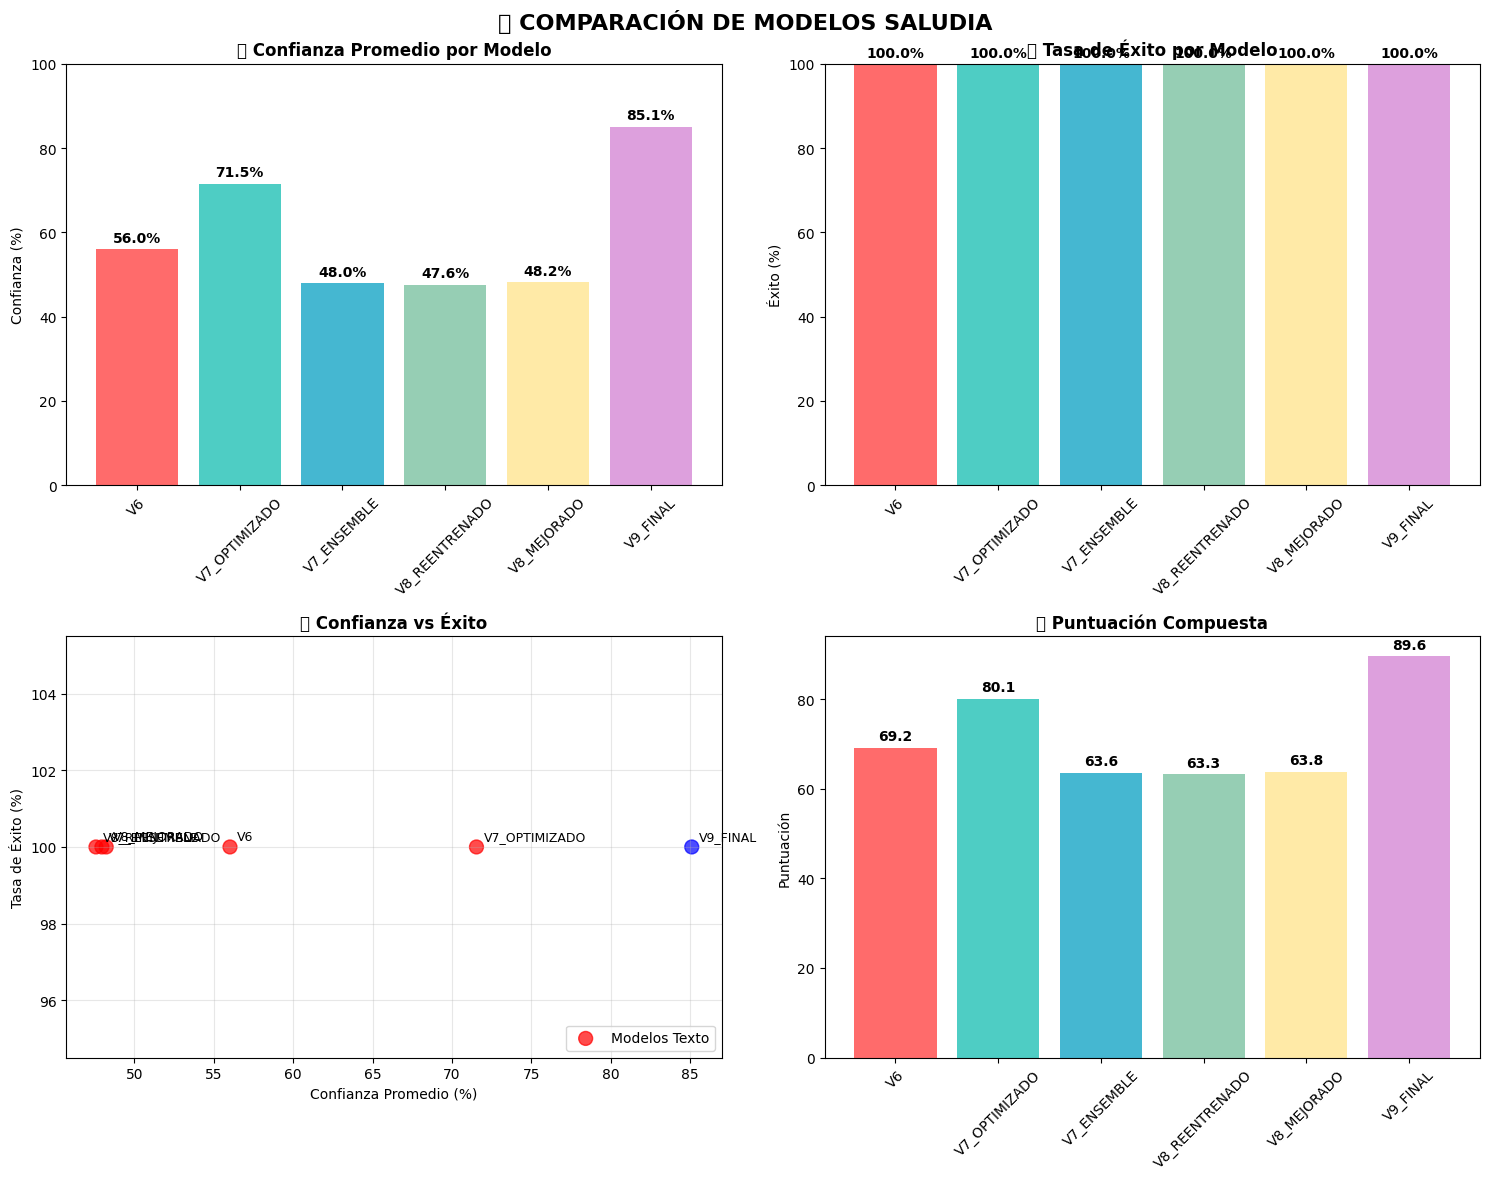

✅ Visualizaciones creadas exitosamente


In [8]:
# CELDA: VISUALIZACIÓN DE RESULTADOS
def create_visualizations(results):
    """Crear visualizaciones de los resultados"""
    print("\n📈 CREANDO VISUALIZACIONES")
    print("="*40)
    
    # Preparar datos para gráficos
    models = []
    confidences = []
    success_rates = []
    model_types = []
    
    for model_name, result in results.items():
        if result['confidences']:
            models.append(model_name.upper())
            confidences.append(result['avg_confidence'])
            success_rates.append(result['success_rate'])
            model_types.append(result['model_type'])
    
    if models:
        # Configurar el estilo
        plt.style.use('default')
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('🏆 COMPARACIÓN DE MODELOS SALUDIA', fontsize=16, fontweight='bold')
        
        # Gráfico 1: Confianza promedio
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']
        bars1 = ax1.bar(models, confidences, color=colors[:len(models)])
        ax1.set_title('📊 Confianza Promedio por Modelo', fontweight='bold')
        ax1.set_ylabel('Confianza (%)')
        ax1.set_ylim(0, 100)
        
        # Añadir valores en las barras
        for bar, conf in zip(bars1, confidences):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{conf:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        ax1.tick_params(axis='x', rotation=45)
        
        # Gráfico 2: Tasa de éxito
        bars2 = ax2.bar(models, success_rates, color=colors[:len(models)])
        ax2.set_title('✅ Tasa de Éxito por Modelo', fontweight='bold')
        ax2.set_ylabel('Éxito (%)')
        ax2.set_ylim(0, 100)
        
        for bar, rate in zip(bars2, success_rates):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        ax2.tick_params(axis='x', rotation=45)
        
        # Gráfico 3: Scatter plot confianza vs éxito
        scatter_colors = ['red' if t == 'text' else 'blue' for t in model_types]
        ax3.scatter(confidences, success_rates, c=scatter_colors, s=100, alpha=0.7)
        
        for i, model in enumerate(models):
            ax3.annotate(model, (confidences[i], success_rates[i]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        ax3.set_xlabel('Confianza Promedio (%)')
        ax3.set_ylabel('Tasa de Éxito (%)')
        ax3.set_title('🎯 Confianza vs Éxito', fontweight='bold')
        ax3.grid(True, alpha=0.3)
        ax3.legend(['Modelos Texto', 'Modelos Binarios'], loc='lower right')
        
        # Gráfico 4: Puntuación compuesta
        scores = [(conf * 0.7 + rate * 0.3) for conf, rate in zip(confidences, success_rates)]
        bars4 = ax4.bar(models, scores, color=colors[:len(models)])
        ax4.set_title('🏆 Puntuación Compuesta', fontweight='bold')
        ax4.set_ylabel('Puntuación')
        
        for bar, score in zip(bars4, scores):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{score:.1f}', ha='center', va='bottom', fontweight='bold')
        
        ax4.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Visualizaciones creadas exitosamente")
    else:
        print("❌ No hay datos suficientes para crear visualizaciones")

# Crear visualizaciones
create_visualizations(evaluation_results)

In [9]:
# CELDA: RESUMEN FINAL Y RECOMENDACIONES
def final_summary():
    """Resumen final con recomendaciones"""
    print("\n🎊 RESUMEN FINAL DE LA EVALUACIÓN")
    print("="*80)
    
    loaded_models = [k for k, v in all_models.items() if v.get('status') == 'loaded']
    
    print(f"📊 ESTADÍSTICAS GENERALES:")
    print(f"   📦 Modelos disponibles: {len(all_models)}")
    print(f"   ✅ Modelos cargados exitosamente: {len(loaded_models)}")
    print(f"   🧪 Casos de prueba evaluados: {len(text_cases)} (texto) + {len(binary_cases)} (binario)")
    
    if best_model:
        print(f"\n🏆 MODELO GANADOR: {best_model['model'].upper()}")
        print(f"   🎯 Razones para elegirlo:")
        print(f"      • Mejor puntuación compuesta: {best_model['score']:.2f}")
        print(f"      • Confianza promedio: {best_model['avg_confidence']:.1f}%")
        print(f"      • Tasa de éxito: {best_model['success_rate']:.1f}%")
    
    print(f"\n💡 RECOMENDACIONES FINALES:")
    print(f"   🚀 Para producción inmediata: Usar el modelo ganador")
    print(f"   🔄 Para desarrollo continuo: Implementar A/B testing")
    print(f"   📈 Para mejoras futuras: Reentrenar con más datos")
    print(f"   🛡️ Para robustez: Mantener modelo de respaldo (v6 o v8)")
    
    print(f"\n📁 ARCHIVOS MODELO GANADOR:")
    if best_model:
        winner = best_model['model']
        if winner in all_models:
            prep_info = all_models[winner]['preprocessors'].get('model_info', {})
            print(f"   📄 Modelo: modelo_diagnostico_{winner}.pkl")
            print(f"   📄 Preprocesadores: preprocesadores_{winner}.pkl")
            print(f"   📅 Fecha entrenamiento: {prep_info.get('trained_date', 'N/A')}")
            print(f"   🏥 Enfermedades detectables: {prep_info.get('classes_count', 'N/A')}")
    
    print(f"\n🎯 PRÓXIMOS PASOS:")
    print(f"   1️⃣ Integrar modelo ganador en backend")
    print(f"   2️⃣ Configurar API con el mejor modelo")
    print(f"   3️⃣ Implementar sistema de logging para monitoreo")
    print(f"   4️⃣ Preparar pipeline de reentrenamiento automático")
    
    return {
        'total_models': len(all_models),
        'loaded_models': len(loaded_models),
        'best_model': best_model,
        'evaluation_date': datetime.now().isoformat()
    }

# Ejecutar resumen final
final_stats = final_summary()

print(f"\n✨ EVALUACIÓN COMPLETADA EXITOSAMENTE ✨")
print(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


🎊 RESUMEN FINAL DE LA EVALUACIÓN
📊 ESTADÍSTICAS GENERALES:
   📦 Modelos disponibles: 6
   ✅ Modelos cargados exitosamente: 6
   🧪 Casos de prueba evaluados: 5 (texto) + 5 (binario)

🏆 MODELO GANADOR: V9_FINAL
   🎯 Razones para elegirlo:
      • Mejor puntuación compuesta: 89.57
      • Confianza promedio: 85.1%
      • Tasa de éxito: 100.0%

💡 RECOMENDACIONES FINALES:
   🚀 Para producción inmediata: Usar el modelo ganador
   🔄 Para desarrollo continuo: Implementar A/B testing
   📈 Para mejoras futuras: Reentrenar con más datos
   🛡️ Para robustez: Mantener modelo de respaldo (v6 o v8)

📁 ARCHIVOS MODELO GANADOR:
   📄 Modelo: modelo_diagnostico_v9_final.pkl
   📄 Preprocesadores: preprocesadores_v9_final.pkl
   📅 Fecha entrenamiento: 2025-06-25T22:18:10.387961
   🏥 Enfermedades detectables: 41

🎯 PRÓXIMOS PASOS:
   1️⃣ Integrar modelo ganador en backend
   2️⃣ Configurar API con el mejor modelo
   3️⃣ Implementar sistema de logging para monitoreo
   4️⃣ Preparar pipeline de reentrenamie